### Critical windows with the causal RF: Analysis Phase 3 ("most realistic")
- The objective of this analysis phase it to perform tests which incorporate correlation between exposure over time. The causal RF may have greater difficulty recovering the effect of correlated exposures.  
- All models use a random draw of 5000 exposure profiles from the cohort's actual exposure profiles, with an outcome based on actual birth weight mean and df. One exposure is confounding the critical exposure(s).   

**Model 3.A:** a naive critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

**Model 3.B:** a time-varying critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

**Model 3.C:** a concentrated critical exposure  
- 6 exposures: 1 critical, 4 not critical, 1 confounder on critical exposure  
- the exposure effect is concentrated (e.g., in week 3); i.e., the full effect of CW in model 1.C is concentrated in a single exposure  

In [278]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from econml.dml import SparseLinearDML
from econml.dml import CausalForestDML
from sklearn.preprocessing import PolynomialFeatures

np.set_printoptions(suppress=True)

In [279]:
np.random.seed(1004)

Cohort information
Get the mean and SD for ozone exposure and birth weight.

In [280]:
births = pd.read_csv("data/birth_w_percentile_confounders.csv")
births.head()

o3_mean = births[['max_o3_01', 'max_o3_02', 'max_o3_03', 'max_o3_04', 
                  'max_o3_05', 'max_o3_06', 'max_o3_07', 'max_o3_08', 
                  'max_o3_09', 'max_o3_10', 'max_o3_11', 'max_o3_12', 
                  'max_o3_13', 'max_o3_14', 'max_o3_15', 'max_o3_16', 
                  'max_o3_17', 'max_o3_18', 'max_o3_19', 'max_o3_20']].values.mean() #births_long['max_o3'].mean()
o3_sd = births[['max_o3_01', 'max_o3_02', 'max_o3_03', 'max_o3_04', 
                'max_o3_05', 'max_o3_06', 'max_o3_07', 'max_o3_08', 
                'max_o3_09', 'max_o3_10', 'max_o3_11', 'max_o3_12', 
                'max_o3_13', 'max_o3_14', 'max_o3_15', 'max_o3_16', 
                'max_o3_17', 'max_o3_18', 'max_o3_19', 'max_o3_20']].values.std() #average_selected_columns = df[['col2', 'col3']].mean() #births_long['max_o3'].std()

bwp_mean = births["bw_percentile"].mean()
bwp_sd = births["bw_percentile"].std()

/var/folders/75/b6cym0892z93rs6dbfy789240000gn/T/ipykernel_10662/4156035646.py:1: DtypeWarning: Columns (15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  births = pd.read_csv("data/birth_w_percentile_confounders.csv")


##### "Data"
A few conventions: `T` is treatments, `W` is confounders (aka controls), and `X` is features (includes confounders and covariates, but not treatment). For all models in this project, `X = W`, as there are no covariates, only confounders.

In [281]:
n_samples = 5000

n_X = 1
n_T = 20
n_W = 1

# treatments / exposures; 10 ppb scale
T_sample = births.sample(n = n_samples, replace = False)

T_01 = (T_sample['max_o3_01'] - o3_mean) / 10
T_03 = (T_sample['max_o3_03'] - o3_mean) / 10
T_02 = (T_sample['max_o3_02'] - o3_mean) / 10
T_04 = (T_sample['max_o3_04'] - o3_mean) / 10
T_05 = (T_sample['max_o3_05'] - o3_mean) / 10
T_06 = (T_sample['max_o3_06'] - o3_mean) / 10
T_07 = (T_sample['max_o3_07'] - o3_mean) / 10
T_08 = (T_sample['max_o3_08'] - o3_mean) / 10
T_09 = (T_sample['max_o3_09'] - o3_mean) / 10
T_10 = (T_sample['max_o3_10'] - o3_mean) / 10
T_11 = (T_sample['max_o3_11'] - o3_mean) / 10
T_12 = (T_sample['max_o3_12'] - o3_mean) / 10
T_13 = (T_sample['max_o3_13'] - o3_mean) / 10
T_14 = (T_sample['max_o3_14'] - o3_mean) / 10
T_15 = (T_sample['max_o3_15'] - o3_mean) / 10
T_16 = (T_sample['max_o3_16'] - o3_mean) / 10
T_17 = (T_sample['max_o3_17'] - o3_mean) / 10
T_18 = (T_sample['max_o3_18'] - o3_mean) / 10
T_19 = (T_sample['max_o3_19'] - o3_mean) / 10
T_20 = (T_sample['max_o3_20'] - o3_mean) / 10


In [282]:
# stack
T_vars = np.vstack((T_01, T_02, T_03, T_04, T_05,
                    T_06, T_07, T_08, T_09, T_10,
                    T_11, T_12, T_13, T_14, T_15,
                    T_16, T_17, T_18, T_19, T_20))

Look at correlation

In [283]:
# ### deprecated
# # ## Confounder coefficient
# # b_W0T9 = -2.5
# # b_W0T10 = -2.5
# # b_W0T11 = -2.5
# # X = b_W0T9 * T_09 + b_W0T10 * T_10 + b_W0T11 * T_11 + np.random.normal(size=n_samples)
# # # z scale
# # X = X / X.std()
# # X = X.to_numpy()

# # confounder all the critical weeks 
# # it's only a critical week if the effect exceeds |1| percentile change
# critical_to_confound = [index for index, value in enumerate(cw_window_type) if value < -1]

# X = [sum(fx) for fx in zip(*T_vars[critical_to_confound]*1.25)] + np.random.normal(size = n_samples, loc = 0, scale = 1)
# # z scale
# X = X / X.std()
# X = pd.Series(X)
# X = X.to_numpy()

# # a 1.25-unit increase in the confounder increases the exposure by 1 unit
# # this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

Create the critical window coefficients

In [284]:
study_period = np.linspace(1, 20, 20)
effect_size = -15 # total reduction of 15 percentiles (based on the average effect of a 200-gram reduction in birthweight, given Sun et al)
# the window should be 9 wide, then 7 wide, then 3 wide
window_start = 6
window_center = 10
window_end = 14

uni_pdf = stats.Uniform(a = window_start, b = window_end)
uni_wide_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 1, b = window_end - 1)
uni_moderate_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 3, b = window_end - 3)
uni_narrow_fx  = uni_pdf.pdf(study_period) * effect_size

norm_pdf = stats.norm.pdf(study_period, window_center, 2.5)
norm_wide_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 1)
norm_moderate_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 0.5)
norm_narrow_fx = norm_pdf * effect_size 

In [285]:
norm_wide_fx

array([-0.00367141, -0.01430453, -0.04749271, -0.13436718, -0.3239458 ,
       -0.66552501, -1.16511633, -1.73814932, -2.20962084, -2.39365368,
       -2.20962084, -1.73814932, -1.16511633, -0.66552501, -0.3239458 ,
       -0.13436718, -0.04749271, -0.01430453, -0.00367141, -0.00080298])

Create confounders on the critical weeks

In [286]:
### deprecated
# ## Confounder coefficient
# b_W0T9 = -2.5
# b_W0T10 = -2.5
# b_W0T11 = -2.5
# X = b_W0T9 * T_09 + b_W0T10 * T_10 + b_W0T11 * T_11 + np.random.normal(size=n_samples)
# # z scale
# X = X / X.std()
# X = X.to_numpy()

# confounder all the critical weeks 
# it's only a critical week if the effect exceeds |1| percentile change
critical_to_confound = [index for index, value in enumerate(norm_moderate_fx) if value < -1] # norm_moderate_fx = cw_window_type

X = [sum(fx) for fx in zip(*T_vars[critical_to_confound]*1.25)] + np.random.normal(size = n_samples, loc = 0, scale = 1)
# z scale
X = X / X.std()
X = pd.Series(X)
X = X.to_numpy()

# a 1.25-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

In [287]:
# get a list of treatment variables, to assign to coefficients
week_list = list(map(str, np.arange(1, 21)))
week_list = [str(num).zfill(2) for num in week_list]

T_vars_names = list(map(lambda item: "T_" + item, week_list))

T_vars = np.vstack((T_01, T_02, T_03, T_04, T_05,
                    T_06, T_07, T_08, T_09, T_10,
                    T_11, T_12, T_13, T_14, T_15,
                    T_16, T_17, T_18, T_19, T_20))

Create the outcome using PDFs

[-0.00367141 -0.01430453 -0.04749271 -0.13436718 -0.3239458  -0.66552501
 -1.16511633 -1.73814932 -2.20962084 -2.39365368 -2.20962084 -1.73814932
 -1.16511633 -0.66552501 -0.3239458  -0.13436718 -0.04749271 -0.01430453
 -0.00367141 -0.00080298]


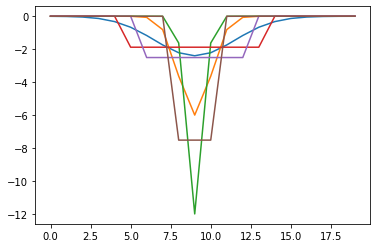

In [288]:
norm_moderate_fx
print(norm_wide_fx)
plt.plot(norm_wide_fx)
plt.plot(norm_moderate_fx)
plt.plot(norm_narrow_fx)
plt.plot(uni_wide_fx)
plt.plot(uni_moderate_fx)
plt.plot(uni_narrow_fx)
plt.show()
# T_vars_names[19]
# tx_fx_list

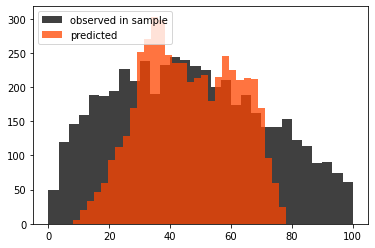

bw mean: 45.955447635931314
y-hat mean 46.188024650331464
bw sd: 24.946087669056993
y-hat sd:  15.260503664058277
SD of noise:  1


In [289]:
# the coefficients and treatment variables
tx_fx, tx = norm_moderate_fx, T_vars
# the vectors of each coefficient * treatment variable
tx_fx_list = [tx[i] * tx_fx[i] for i in np.arange(0, 20)] #0, 20 # when testing interactoin: (8, 10)
# total treatment effect by individual
total_tx_fx = [sum(fx) for fx in zip(*tx_fx_list)]

# the confounder effect (z-scaled, see above)
b_W0y = 1.5
# the vector of confounder effects
wx_fx = X * b_W0y

# bit of noise
noise_sd = 1
e = np.random.normal(size=n_samples, loc = 0, scale = 1)

# intercept
b_int = bwp_mean

# interaction effect
# b_intx = -200
# intx_fx = b_intx * tx[8] * tx[9] #[b_intx * tx[i] for i in np.arange(8, 10)]

y = b_int + total_tx_fx + wx_fx + e# + intx_fx


plt.hist(T_sample["bw_percentile"], bins = 30,
         alpha = 0.75,# edgecolor = "white", 
         color = "black",
         label = "observed in sample")
plt.hist(y, bins = 30, alpha = 0.75,
         #edgecolor = "white",
         color = "orangered", 
         label = "predicted")
plt.legend(loc = 'upper left')
plt.show()

print("bw mean:", bwp_mean)
print("y-hat mean", sum(y) / len(y))
print("bw sd:", bwp_sd)
print("y-hat sd: ", np.std(y))
print("SD of noise: ", noise_sd)

Matrices for treatments, confounders

In [290]:
T = pd.DataFrame({'noncritical_tx_01': T_01, 'noncritical_tx_02': T_02, 
                  'noncritical_tx_03': T_03, 'noncritical_tx_04': T_04, 
                  'noncritical_tx_05': T_05, 'noncritical_tx_06': T_06, 
                  'noncritical_tx_07': T_07, 'critical_tx_08': T_08, 
                  'critical_tx_09': T_09, 'critical_tx_10': T_10,
                  'critical_tx_11': T_11, 'critical_tx_12': T_12, 
                  'noncritical_tx_13': T_13, 'noncritical_tx_14': T_14, 
                  'noncritical_tx_15': T_15, 'noncritical_tx_16': T_16, 
                  'noncritical_tx_17': T_17, 'noncritical_tx_18': T_18, 
                   'noncritical_tx_19': T_19, 'noncritical_tx_20': T_20})
X = pd.DataFrame(X, columns=['confounder'])

##### Causal RF  

In [291]:
# featurizer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False, order = 'F')

# X_interactions = featurizer.fit_transform(T)

# test = SparseLinearDML(model_t='forest',
#                        model_y='forest',
#                        discrete_treatment=False,# treatment_featurizer=featurizer,
#                        #n_estimators=500,# 
#                        n_jobs = 4)

# test.fit(y, T = X, X = X, W = X)
# test.marginal_ate_inference(T, X)

In [294]:
# featurizer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False, order = 'F')

est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500,# treatment_featurizer=featurizer,
                      n_jobs = 4)

est.fit(y, T=T, X=X, W=X)
# takes 20-40 seconds w/ 5000
# takes 50-65 seconds w/ 10000
# second-order interactions:
## 6 variables: 13 s
## 8 variables: 23 s
## 10 variables: 39 s
## all should run in 13 m?

Extract the marginal effects

In [295]:
# takes 20-30 seconds

# est.marginal_effect_inference(T, X)
# test = est.marginal_effect_inference(T, X)
# test.population_summary()
# (T, X)
## -40.3 vs -40.1
## -65.2 vs. -66.2

est.marginal_ate_inference(T, X)

,mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
T0,0.028,0.347,0.08,0.937,-0.653,0.709
T1,-0.015,0.346,-0.043,0.966,-0.692,0.663
T2,-0.058,0.351,-0.166,0.868,-0.746,0.629
T3,0.073,0.38,0.192,0.848,-0.672,0.817
T4,-0.021,0.366,-0.058,0.954,-0.739,0.697
T5,0.001,0.362,0.003,0.997,-0.708,0.71
T6,-0.043,0.377,-0.115,0.908,-0.783,0.696
T7,-0.853,0.376,-2.269,0.023,-1.589,-0.116
T8,-3.71,0.434,-8.555,0.0,-4.56,-2.86
T9,-5.911,0.427,-13.839,0.0,-6.749,-5.074


In [59]:
print(est.cate_treatment_names()) # all interact with all
est.const_marginal_ate_inference(X)

['noncritical_tx_01', 'noncritical_tx_02', 'noncritical_tx_03', 'noncritical_tx_04', 'noncritical_tx_05', 'noncritical_tx_06', 'noncritical_tx_07', 'critical_tx_08', 'critical_tx_09', 'critical_tx_10', 'critical_tx_11', 'critical_tx_12', 'noncritical_tx_13', 'noncritical_tx_14', 'noncritical_tx_15', 'noncritical_tx_16', 'noncritical_tx_17', 'noncritical_tx_18', 'noncritical_tx_19', 'noncritical_tx_20']


,mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
T0,0.081,0.392,0.207,0.836,-0.688,0.85
T1,0.038,0.388,0.098,0.922,-0.723,0.799
T2,-0.098,0.398,-0.245,0.807,-0.878,0.683
T3,0.032,0.406,0.078,0.938,-0.765,0.828
T4,-0.036,0.404,-0.089,0.929,-0.828,0.756
T5,-0.042,0.401,-0.105,0.917,-0.827,0.743
T6,-0.064,0.439,-0.145,0.885,-0.924,0.796
T7,-0.815,0.411,-1.982,0.047,-1.621,-0.009
T8,-3.725,0.475,-7.844,0.0,-4.656,-2.794
T9,-5.912,0.471,-12.558,0.0,-6.835,-4.989


In [60]:
# Extract all values once
treatments = np.array(est.cate_treatment_names())
means = np.array(est.marginal_ate(T, X))
ci_lower, ci_upper = est.marginal_ate_interval(T, X)

# Construct DataFrame directly
res_df = pd.DataFrame({
    'treatment': treatments,
    'mean': means,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

res_df

,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_01,0.081216,-0.687814,0.850246
1,noncritical_tx_02,0.038195,-0.722521,0.798910
2,noncritical_tx_03,-0.097532,-0.877998,0.682934
3,noncritical_tx_04,0.031561,-0.764860,0.827982
4,noncritical_tx_05,-0.035917,-0.828088,0.756254
5,noncritical_tx_06,-0.041991,-0.827461,0.743480
6,noncritical_tx_07,-0.063752,-0.923924,0.796420
7,critical_tx_08,-0.814919,-1.620747,-0.009091
8,critical_tx_09,-3.725074,-4.655801,-2.794346
9,critical_tx_10,-5.912035,-6.834726,-4.989345


Plot the marginal effects

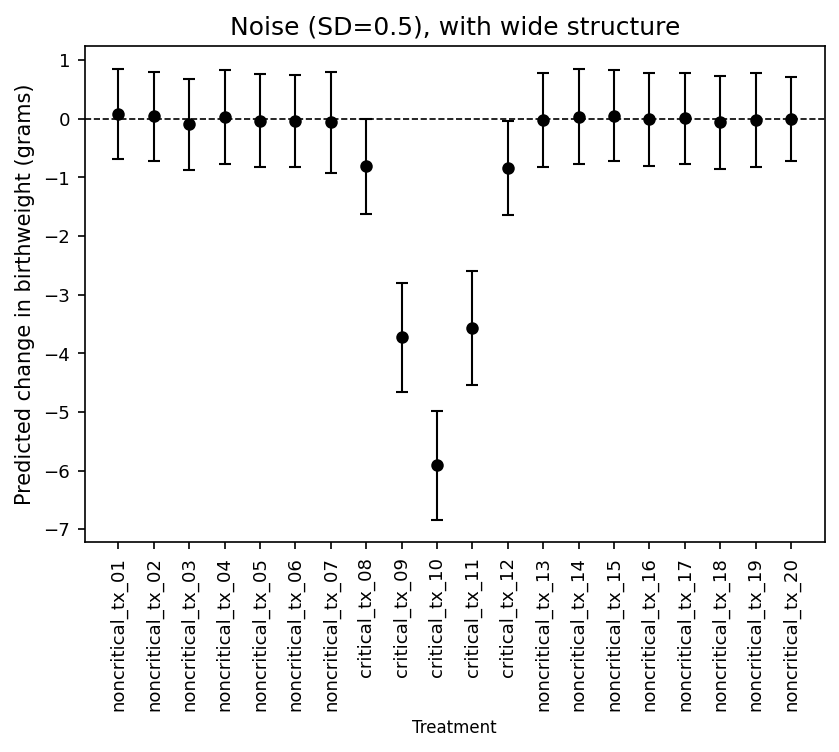

In [61]:
plt.figure(figsize=(6, 4), dpi=150)
# ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
ci = np.array([res_df['mean'] - res_df['ci_lower'], res_df['ci_upper'] - res_df['mean']])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8.7)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
plt.xticks(rotation=90)
plt.title("Noise (SD=0.5), with wide structure")
# plt.savefig('raw_forest_plot.png')
plt.show()